<a href="https://www.kaggle.com/code/milicaradisavljevic/marketing-a-b-testing?scriptVersionId=188995918" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# About the data

It is in the interest of companies to provide users with content based on their interests, and thus to collect as many permanent users as possible. In order to find out what users like the most, A/B testing is usually applied. An experiment can be used to check how successful a change on the site is, in the form of color, shape, position, or it can be the placement of an advertising block. Usually, one group of respondents is assigned a modified site and the number of visits is monitored, and the other a standard site. The dataset that will be used is Kaggle's "Marketing A/B Testing".

Dataset link: https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing

Key attributes:

- Index: Row index;
- user id: Unique users ID;
- test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
- converted: If a person bought the product then True, else is False:
- total ads: Amount of ads seen by person;
- most ads day: Day that the person saw the biggest amount of ads;
- most ads hour: Hour of day that the person saw the biggest amount of ads.

# Objectives

- Analyze the groups (EDA); 
- Find if the ads were successful; 
- Applie hypothesis tests and reache appropriate conclusions.


# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import scipy.stats as stats 
from scipy.stats import normaltest

In [2]:
import warnings 
warnings.filterwarnings('ignore')

# Load the data

In [3]:
data = pd.read_csv("/kaggle/input/marketing-ab-testing/marketing_AB.csv")
data.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [4]:
data.rename(columns={"test group": "test_group"}, inplace=True)
data.rename(columns={"converted": "purchased"}, inplace=True)
data.rename(columns={"total ads": "total_ads"}, inplace=True)
data.rename(columns={"most ads day": "most_ads_day"}, inplace=True)
data.rename(columns={"most ads hour": "most_ads_hour"}, inplace=True)

# EDA

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test_group     588101 non-null  object
 3   purchased      588101 non-null  bool  
 4   total_ads      588101 non-null  int64 
 5   most_ads_day   588101 non-null  object
 6   most_ads_hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


The dataset contains 588101 entries and 7 columns. We have 2 categorical columns and 4 numerical columns and 1 bool column. Also, we dont have null values. The first column "Unnamed:0" represents the index column and is not important, so we will remove it. We will also remove the "user id" column because it is not useful for further analysis.



In [6]:
#checking if we have duplicates in dataset
data.duplicated().sum()

0

In [7]:
data = data.drop(["Unnamed: 0", "user id"], axis=1)

In [8]:
data.columns

Index(['test_group', 'purchased', 'total_ads', 'most_ads_day',
       'most_ads_hour'],
      dtype='object')

## Univariate analysis

### Numerical columns

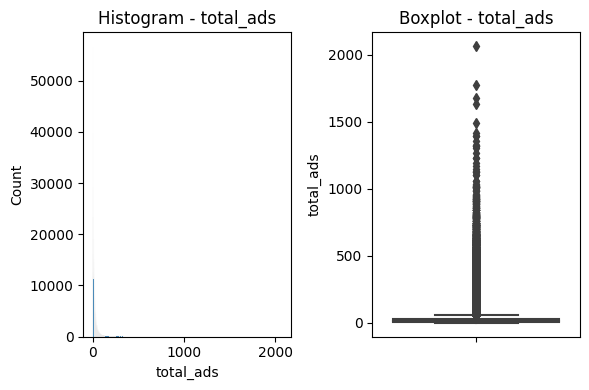

In [9]:
variable ="total_ads"

plt.figure(figsize = (6,4))

#histogram
plt.subplot(1,2,1)
sns.histplot(x = variable, data = data)
plt.title(f"Histogram - {variable}")

#boxplot
plt.subplot(1,2,2)
sns.boxplot(y=variable, data=data)
plt.title(f"Boxplot - {variable}")

#Adjust layout
plt.tight_layout()

#show the plots
plt.show()

In [10]:
#checking descriptive statistic for numerical column total ads
data["total_ads"].describe()

count    588101.000000
mean         24.820876
std          43.715181
min           1.000000
25%           4.000000
50%          13.000000
75%          27.000000
max        2065.000000
Name: total_ads, dtype: float64

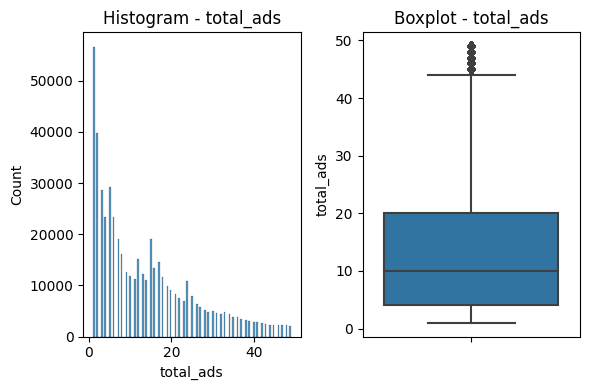

In [11]:
variable ="total_ads"

plt.figure(figsize = (6,4))

#histogram
plt.subplot(1,2,1)
sns.histplot(x = variable, data = data[data["total_ads"]<50])
plt.title(f"Histogram - {variable}")

#boxplot
plt.subplot(1,2,2)
sns.boxplot(y=variable, data=data[data["total_ads"]<50])
plt.title(f"Boxplot - {variable}")

#Adjust layout
plt.tight_layout()

#show the plots
plt.show()

We wanted to see amount of ads seen by person, but first plot was not so good, so we checked with descriptive statistics where 75% is. That's 27. We'll try a slightly higher number, say 50, because we have to pay attention to the outliers. 

We can see that median is on 10, and it usualy means that 50% of the data points are below 10 and 50% are above 10. Box (Interquartile Range - IQR): the range between the 25th(lower quartile Q1) and 75th percentile(upper quartile Q3). Finaly, we have min and max scores without outliers. Data points outside this range are considered as outliers. In our case, the median leans more towards Q1, which indicates skewness. In our case, the median leans more towards Q1, which indicates skewness and that the number shown to users is much higher than 10.

### Categorical columns

In the continuation of the analysis, we treat the column "most ads hour" because it contains the same content, content of a similar type as "most ads day".

In [12]:
data_categorical = data[["test_group", "purchased", "most_ads_day", "most_ads_hour"]]
#Return number of unique values in the object
data_categorical.nunique()

test_group        2
purchased         2
most_ads_day      7
most_ads_hour    24
dtype: int64

In [13]:
for i in data_categorical.columns:
    print(i.upper(), ":", data_categorical[i].unique())

TEST_GROUP : ['ad' 'psa']
PURCHASED : [False  True]
MOST_ADS_DAY : ['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday' 'Sunday' 'Thursday']
MOST_ADS_HOUR : [20 22 18 10 14 13 19 11 12 16 21  3 23  4  8  0  2 15  1  6 17  7  9  5]


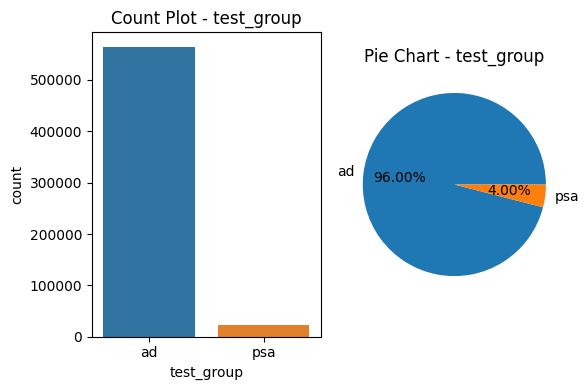

In [14]:
variable ="test_group"

plt.figure(figsize = (6,4))

#count plot
plt.subplot(1,2,1)
sns.countplot(x = variable, data = data_categorical)
plt.title(f"Count Plot - {variable}")

#pie chart
plt.subplot(1,2,2)
counts = data_categorical[variable].value_counts()
plt.pie(counts, labels = counts.index, autopct = "%0.2f%%")
plt.title(f"Pie Chart - {variable}")

#Adjust layout
plt.tight_layout()

#show the plots
plt.show()

96% of people are in the ad group and were shown the advertisement, while 4% of people are in the psa group and were shown the public service announcement.

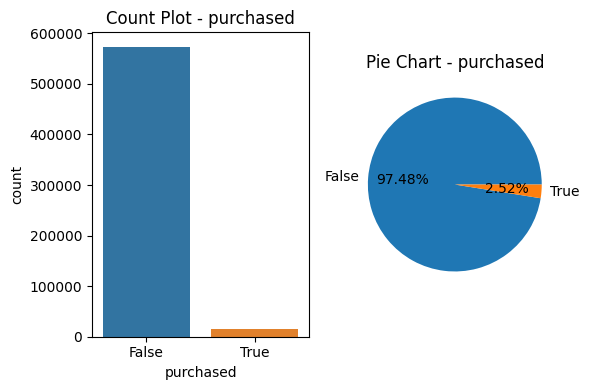

In [15]:
variable ="purchased"

plt.figure(figsize = (6,4))

#count plot
plt.subplot(1,2,1)
sns.countplot(x = variable, data = data_categorical)
plt.title(f"Count Plot - {variable}")

#pie chart
plt.subplot(1,2,2)
counts = data_categorical[variable].value_counts()
plt.pie(counts, labels = counts.index, autopct = "%0.2f%%")
plt.title(f"Pie Chart - {variable}")

#Adjust layout
plt.tight_layout()

#show the plots
plt.show()

True - the product was purchased, false - the service was refused. We have 97,48% False which is not good.

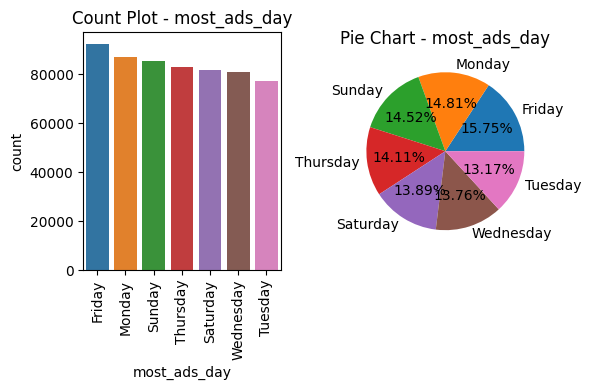

In [16]:
variable ="most_ads_day"

plt.figure(figsize = (6,4))

#count plot
plt.subplot(1,2,1)
sns.countplot(x = variable, data = data_categorical, order = data_categorical["most_ads_day"].value_counts().index)
plt.title(f"Count Plot - {variable}")
#rotate the text for clarity
plt.xticks(rotation=90)

#pie chart
plt.subplot(1,2,2)
counts = data_categorical[variable].value_counts()
plt.pie(counts, labels = counts.index, autopct = "%0.2f%%")
plt.title(f"Pie Chart - {variable}")

#Adjust layout
plt.tight_layout()

#show the plots
plt.show()

Day that the person saw the biggest amount of ads is friday with 15.75%, than monday with 14.81% and at third place we have sunday with 14.52%. Pie Chrts are much more profitable with a smaller number of values, but in our case this is enough to get important information.


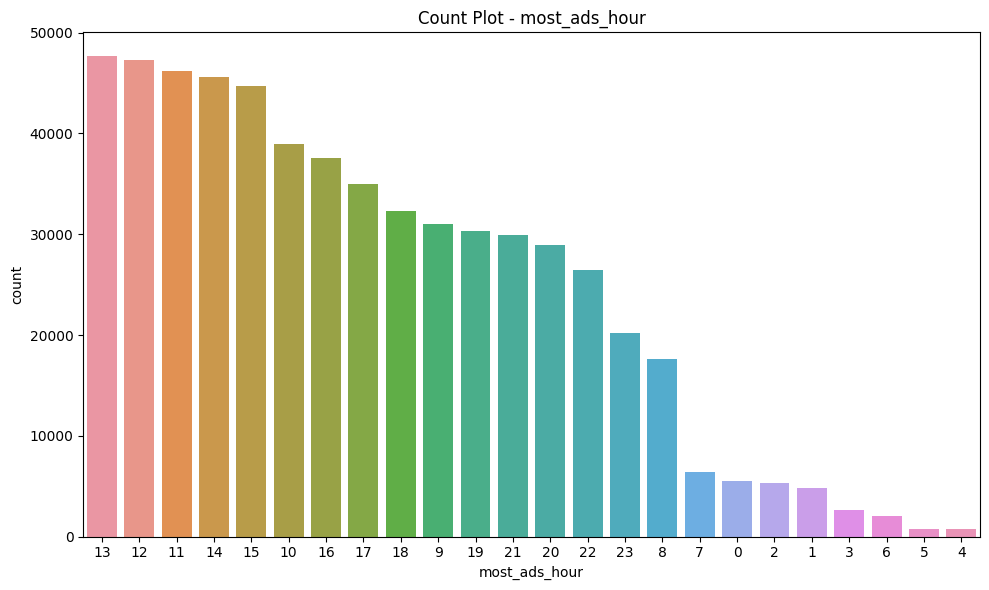

In [17]:
variable ="most_ads_hour"

plt.figure(figsize = (10,6))

#count plot
plt.subplot(1,1,1)
sns.countplot(x = variable, data = data_categorical, order = data_categorical["most_ads_hour"].value_counts().index)
plt.title(f"Count Plot - {variable}")

#Adjust layout
plt.tight_layout()

#show the plots
plt.show()

The largest number of advertisements are shown from 13:00 to 15:00, and most often during breaks or lunch. The lowest number of ads is shown from 4 to 7, which is expected, because it is expected that people are sleeping at that time and not using the platforms.


## Bivariate analysis

In the following, we will compare all columns with the target column "converted". For numerical column we will use boxplot, and for categorical we will create a crosstab thats taking 2 categorical variables, where one is the target variable. Normalization means that we divide it by the total number of rows. 

### Numerical columns

<Axes: xlabel='purchased', ylabel='total_ads'>

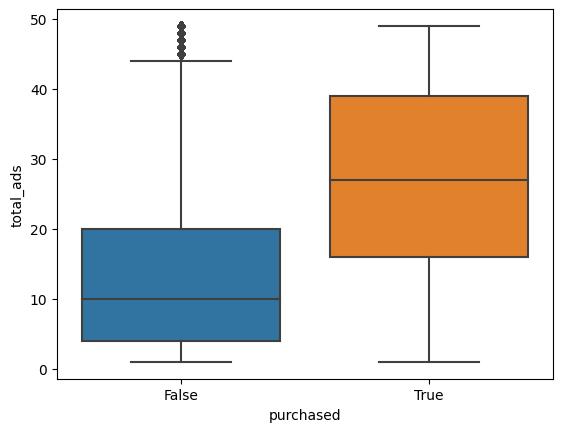

In [18]:
#as before, we will look values lower than 50
sns.boxplot(x="purchased", y="total_ads", data=data[data["total_ads"]<50])

Based on the plot, the average number of people who made a purchase saw the ad roughly 27 times, while the average number of people who did not make a purchase saw the ad about 10 times.

### Categorical columns

In [19]:
ct_conversion_test_group = pd.crosstab(data["test_group"], data["purchased"], normalize = "index")
ct_conversion_test_group

purchased,False,True
test_group,,
ad,0.974453,0.025547
psa,0.982146,0.017854


<Axes: xlabel='test_group'>

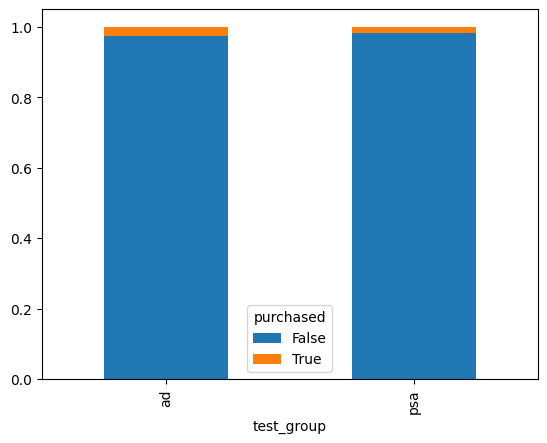

In [20]:
ct_conversion_test_group.plot.bar(stacked = True)

Of the people who saw the ad, 2.5% bought something. Of the people who saw the regular post, 1.7% bought something.

purchased        False     True 
most_ads_day                    
Monday        0.967188  0.032812
Tuesday       0.970160  0.029840
Wednesday     0.975058  0.024942
Sunday        0.975524  0.024476
Friday        0.977788  0.022212
Thursday      0.978429  0.021571
Saturday      0.978949  0.021051


<Axes: xlabel='most_ads_day'>

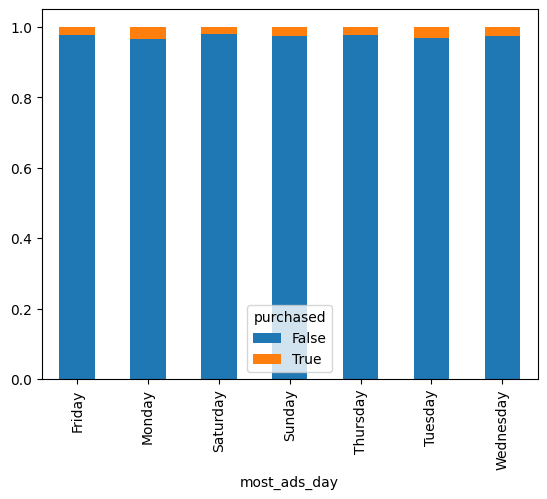

In [21]:
ct_conversion_day = pd.crosstab(data["most_ads_day"], data["purchased"], normalize = "index")
print(ct_conversion_day.sort_values(by=True, ascending=False))
ct_conversion_day.plot.bar(stacked = True)

On Monday, the largest number of purchases were made with 3.2%, while on the weekend, on Saturday, the smallest number was made. Let's assume that people are then engaged in other activities.

purchased         False     True 
most_ads_hour                    
16             0.969228  0.030772
20             0.970197  0.029803
15             0.970347  0.029653
21             0.971077  0.028923
17             0.971790  0.028210
14             0.971937  0.028063
18             0.972620  0.027380
19             0.973280  0.026720
22             0.973895  0.026105
13             0.975323  0.024677
12             0.976172  0.023828
23             0.977338  0.022662
6              0.977756  0.022244
11             0.977884  0.022116
10             0.978479  0.021521
5              0.979085  0.020915
8              0.980484  0.019516
9              0.980809  0.019191
0              0.981575  0.018425
7              0.981889  0.018111
4              0.984765  0.015235
1              0.987089  0.012911
3              0.989548  0.010452
2              0.992687  0.007313


<Axes: xlabel='most_ads_hour'>

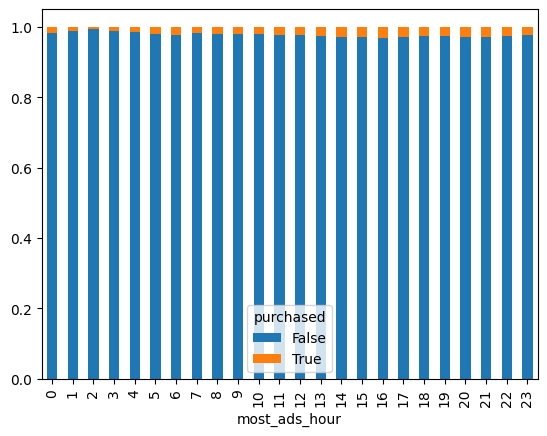

In [22]:
ct_conversion_hour = pd.crosstab(data["most_ads_hour"], data["purchased"], normalize = "index")
print(ct_conversion_hour.sort_values(by=True, ascending=False))
ct_conversion_hour.plot.bar(stacked = True)

The largest number of purchases was made at 4 p.m. with 3%. As a result, purchases increase the most from 10 a.m. to 11 p.m.

# Statistical tests

## Categorical columns

- Null hypothesis: There is no significant difference in purchasing across {variable};
- Alternative hypothesis: The difference in purchasing across {variable} is statisticly significant.

variable - "test group", "most ads day", "most ads hour"

decision criteria: alpha = 0.05

test: **chi-squared test** - usualy used for testing the association between two categorical variables (association beween "purchased" column and {variable})

In [23]:
# Set decision criteria
alpha = 0.05

# Loop through each column in data_categorical
for variable in data_categorical.columns:
    if variable == "purchased":
        continue  # Skip the "converted" column itself

    # Create a contingency table
    contingency_table = pd.crosstab(data_categorical[variable], data_categorical["purchased"])

    # Perform chi-squared test(chi-square statistic, p_value, degree of freedom, expected frequencies)
    chi2, p_val, dof, exp_freq = chi2_contingency(contingency_table, correction = False)

    # Display the results
    print('chi-square statistic: {} , p_value: {}'.format(chi2, p_val))
    
    # Check if p-value is greater than alpha
    if p_val > alpha:
        print(f"There is no significant difference in purchasing across {variable}.")
    else:
        print(f"The difference in purchasing across {variable} is statisticly significant.")

chi-square statistic: 54.318051591383124 , p_value: 1.7052807161560133e-13
The difference in purchasing across test_group is statisticly significant.
chi-square statistic: 410.0478857936585 , p_value: 1.932184379244731e-85
The difference in purchasing across most_ads_day is statisticly significant.
chi-square statistic: 430.76869230822086 , p_value: 8.027629823696771e-77
The difference in purchasing across most_ads_hour is statisticly significant.


In all three tests p-value is lower than alpha, so we conclude that we can **reject null hypothesis**  and that the difference in purchasing across test groups, the days the ads are shown, as well as the hours is statisticly significant.

## Numerical columns

In [24]:
# Convert boolean column to integer
data['purchased'] = data['purchased'].astype(int)

In [25]:
data.head()

,test_group,purchased,total_ads,most_ads_day,most_ads_hour
0,ad,0,130,Monday,20
1,ad,0,93,Tuesday,22
2,ad,0,21,Tuesday,18
3,ad,0,355,Tuesday,10
4,ad,0,276,Friday,14


In [26]:
#purchasing observations
person_purchased = data.loc[data.purchased== 1]
person_not_purchased = data.loc[data.purchased== 0]

In [27]:
#total ads for purchasing
person_purchased_total_ads = person_purchased.total_ads
person_not_purchased_total_ads = person_not_purchased.total_ads

First we need to check the distributions for normality.

- Null hypothesis: Both distributions are normal;
- Alternative hypothesis: The distributions is not normal.

decision criteria: alpha = 0.05

variables: person_purchased_total_ads and person_not_purchased_total_ads

test: **normality test**

The normaltest function evaluates whether a dataset significantly deviates from a normal distribution based on skewness and kurtosis, providing a test statistic and p-value to help determine if the data is normally distributed.

<Axes: xlabel='total_ads', ylabel='Density'>

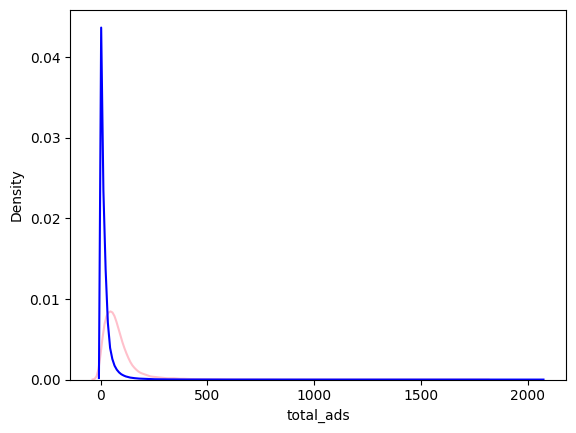

In [28]:
#plot total ads distributions
sns.distplot(person_purchased_total_ads,color='pink',hist=False)
sns.distplot(person_not_purchased_total_ads,color='blue',hist=False)

In [29]:
normaltest(person_purchased_total_ads.values)

NormaltestResult(statistic=14964.884693956345, pvalue=0.0)

In [30]:
normaltest(person_not_purchased_total_ads.values)

NormaltestResult(statistic=776265.6263277293, pvalue=0.0)

Since the p-value is less than any conventional alpha level (0.05), we reject the null hypothesis. This means that the **data significantly deviates from a normal distribution**.

Since we do not have a normal distribution, we will use the **Mann-Whitney U test**, instead of the t test. Unlike the t-test that compares the means of numerical columns, the Mann-Whitney U Test compares the distributions.

- Null hypothesis: Purchasing is the same for amount of ads seen by person;
- Alternative hypothesis: Purchasing is not the same for amount of ads seen by person;

decision criteria: alpha = 0.05

variables: person_purchased_total_ads and person_not_purchased_total_ads

In [31]:
u_stat, u_p_value = stats.mannwhitneyu(person_purchased_total_ads, person_not_purchased_total_ads)
print("u_stat = ",u_stat, ", u_p_value = ", u_p_value)

u_stat =  7269106736.0 , u_p_value =  0.0


A p-value of 0.0 indicates that there is a statistically significant difference between the distribution of "total_ads" for individuals who purchased and those who did not.

- We rejected the null hypothesis;
- Purchasing is not the same for amount of ads seen by person.

# Conclude

- Based on chi-squared tests, we conclude that we can reject null hypothesis and that the difference in purchasing across test groups, the days the ads are shown, as well as the hours is statisticly significant;
- Based on normality test we conclude that columns person_purchased and person_not_purchased significantly deviates from a normal distribution;
- Purchasing is not the same for amount of ads seen by person. A p-value of 0.0 indicates that there is a statistically significant difference between the distribution of "total_ads" for individuals who purchased and those who did not;
- We noticed that people who saw an ad more than once ended up making a purchase, so we conclude that persistently displaying ads is profitable for the company.